In [1]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [2]:
from array import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH2D, std_color_list
from categoriesDef import categories as categoriesDef

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 6*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [4]:
dataLoc = '../data/cmsRD/skimmed/B2DstMu_B0_201101_NoCat_corr.root'
branches = ['mu_pt', 'mu_eta', 'mu_phi', 'mu_sigdxy',
            'cat_low', 'cat_mid', 'cat_high',
            'muPass_Mu12_IP6', 'muPass_Mu9_IP6', 'muPass_Mu7_IP4',
           ]
df = pd.DataFrame(rtnp.root2array(dataLoc, branches=branches))

In [5]:
' '.join(df.columns)

'mu_pt mu_eta mu_phi mu_sigdxy cat_low cat_mid cat_high muPass_Mu12_IP6 muPass_Mu9_IP6 muPass_Mu7_IP4'

# General plots

In [6]:
print 'Max eta', np.max(np.abs(df['mu_eta']))

Max eta 1.5002864599227905


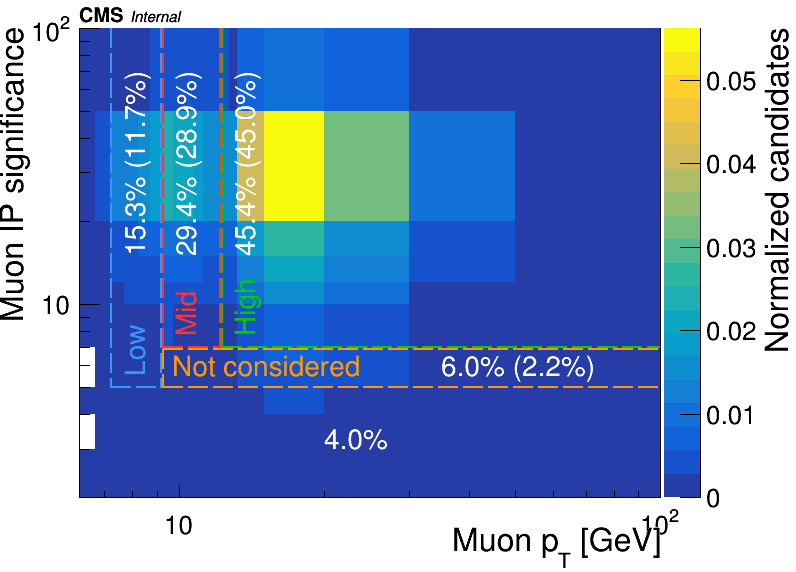

In [7]:
ptBins = array('d', list(np.arange(6.2, 13.4, 0.5)) + [15, 20, 30, 50, 100] )
ipBins = array('d', [0, 2, 3] + list(np.arange(4, 10, 1)) + [10, 12, 15, 20, 50, 100])

h = create_TH2D(np.array(df[['mu_pt', 'mu_sigdxy']]), 
                binning=[ptBins, ipBins], 
                axis_title=['Muon p_{T} [GeV]', 'Muon IP significance', 'Normalized candidates'],
                scale_histo='norm',
               )
h.GetYaxis().SetTitleOffset(0.85)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.17, mL=0.1)
c.SetLogy()
c.SetLogx()
# c.SetLogz()

eps = 1.005
t = rt.TText()
t.SetTextColor(0)
t.SetTextFont(43)
t.SetTextSize(30)
t.SetTextAngle(90)

nTot = float(df.shape[0])
effTot = 0
selTot = np.zeros_like(df['mu_pt'])
for ic, cn in enumerate(['low', 'mid', 'high']):
    cat = categoriesDef[cn]
    
    sel = np.logical_and(df['mu_pt'] > cat.min_pt, df['mu_pt'] < cat.max_pt)
    sel = np.logical_and(sel, df['mu_sigdxy'] > cat.minIP)
    selTot = np.logical_or(selTot, sel)
    effRegion = np.sum(sel)/nTot
    effTot += effRegion
    effTrg = np.sum(np.logical_and(sel, df['muPass_'+cat.trg]))/nTot
    
    t.SetTextColor(0)
    t.DrawText(cat.min_pt*1.18, 15, '{:.1f}% ({:.1f}%)'.format(100*effRegion, 100*effTrg))
    
    t.SetTextColor(std_color_list[ic])
    t.DrawText(cat.min_pt*1.18, cat.minIP*1.1, cat.name)
    
    cl.SetLineColor(std_color_list[ic])
    M = min(cat.max_pt, np.max(ptBins))
    cl.DrawLine(cat.min_pt*eps, cat.minIP, M/eps, cat.minIP)
    cl.DrawLine(cat.min_pt*eps, cat.minIP, cat.min_pt*eps, np.max(ipBins))
    if not cn == 'high': cl.DrawLine(M/eps, cat.minIP, M/eps, np.max(ipBins))
        

# Add excluded region
cat = categoriesDef['low']
selIP = np.logical_and(df['mu_sigdxy'] > cat.minIP, 
                   df['mu_sigdxy'] < categoriesDef['mid'].minIP)
selExcluded = np.logical_and(selIP, df['mu_pt'] > cat.max_pt)
cl.SetLineColor(std_color_list[3])
cl.DrawLine(cat.max_pt*eps, cat.minIP, np.max(ptBins)/eps, cat.minIP)
cl.DrawLine(cat.max_pt*eps, categoriesDef['mid'].minIP/(0.01+eps), 
            np.max(ptBins)/eps, categoriesDef['mid'].minIP/(0.01+eps))
cl.DrawLine(cat.max_pt*eps, cat.minIP, cat.max_pt*eps, categoriesDef['mid'].minIP/(0.01+eps))
t.SetTextAngle(0)
t.SetTextColor(std_color_list[3])
t.DrawText(cat.max_pt*1.05, cat.minIP*1.1, 'Not considered')
t.SetTextColor(0)
effRegion = np.sum(selExcluded)/nTot
effTrg = np.sum(np.logical_and(selExcluded, df['muPass_'+cat.trg]))/nTot
t.DrawText(35, cat.minIP*1.1, '{:.1f}% ({:.1f}%)'.format(100*effRegion, 100*effTrg))

effTot += effRegion

t.SetTextColor(0)
t.DrawText(20, 3, '{:.1f}%'.format(100*(1-effTot)))

c.SaveAs('../../public_html/BPH_RDst/categoriesDefinitionEffData.png')